In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# from deepctr.models import DeepFM
# from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names

# 数据集介绍

## 数据集

参考 https://github.com/chengstone/kaggle_criteo_ctr_challenge- . train.txt文件11.7G 共45840617 行，test.txt文件 1.35G 共 6042135 行。

#### Label 
- Target variable that indicates if an ad was clicked (1) or not (0).

#### I1-I13 
- A total of 13 columns of integer features (mostly count features).

#### C1-C26 
- A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 


为避免数据集过大，这里随机采样了部分数据

```python
# 训练集过大，随机采样100万行
import dask.dataframe as dd
df = dd.read_csv('criteo/train.txt',sep='\t',header=None)
df.columns = ['label']+ ['I' + str(i) for i in range(1, 14)]+['C' + str(i) for i in range(1, 27)]
#n = df.shape[0].compute() #45840617 
df = df.sample(frac = 0.02)
# 转到内存中
df = df.compute()
df.to_csv('criteo/train_sample.txt',index=False,sep = '\t')

# 训练集过大，随机采样100万行
df = dd.read_csv('criteo/test.txt',sep='\t',header=None)
df.columns =  ['I' + str(i) for i in range(1, 14)]+['C' + str(i) for i in range(1, 27)]
# n = df.shape[0].compute() #6042135
df = df.sample(frac = 0.02)
# 转到内存中
df = df.compute()
df.to_csv('criteo/test_sample.txt',index=False,sep = '\t')
```

利用 包可视化代码

```python
import pandas_profiling
# 2.4.0 版本以上可以设置 minimal=True, 这样相关性分析会取消，以加快速度 
pfr = pandas_profiling.ProfileReport(df.sample(10000),title = 'criteo 数据集探索性分析')
pfr.to_file('eda_criteo_.html')
```



In [2]:
df= pd.read_csv('data/train.csv')
df.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,NaN,21,24.0,10.0,8336.0,333.0,2.0,48.0,161.0,...,3486227d,29907d97,21ddcdc9,a458ea53,635efd7f,NaN,bcdee96c,38be899f,001f3601,c26ea7d4
1,0,0.0,31,19.0,5.0,2279.0,150.0,1.0,11.0,78.0,...,d4bb7bd8,582152eb,21ddcdc9,5840adea,d448e8f3,c9d4222a,3a171ecb,29d7ccf8,001f3601,aa5f0a15
2,0,NaN,0,NaN,3.0,301485.0,NaN,0.0,0.0,115.0,...,1e88c74f,262c8681,NaN,NaN,11d8c4ba,ad3062eb,3a171ecb,03aefe56,NaN,NaN
3,0,NaN,1301,4.0,4.0,5506.0,21.0,7.0,4.0,26.0,...,e5ba7672,92555263,NaN,NaN,242bb710,c9d4222a,3a171ecb,72c78f11,NaN,NaN
4,1,NaN,5,14.0,5.0,41952.0,NaN,0.0,5.0,17.0,...,1e88c74f,a1d0cc4f,efa3470f,a458ea53,44d0afc8,ad3062eb,32c7478e,63df507a,cb079c2d,55385467


# 特征 check 模块解构

## 一、初始化

基础的特征描述欲包含这三个部分：

### (1) 密度分布 density p(x)、p(y)

- 对于连续变量，p(x) 可以由 KDE 估计来完成
- 对于离散变量，p(x) 可以直接统计

### (2) 联合分布 p(x,y)

- 对于连续变量，p(x,y) 理论上也可以由 KDE 估计来完成，也可通过 $ p(x,y) = p(y|x) * p(x) = p(x|y) * p(y)$ 来完成
- 对于离散变量，p(x,y) 即是列联合，可以通过 crosstab 直接计算，存储为一个 dict 即可 `pd.crosstab(x,y).stack().to_dict()`

### (3) 条件概率 p(x|y)、p(y|x)

- 对于连续变量，如果不保证光光滑，p(y|x) 可以根据已经选定的 bw 来计算，p(x|y) 则由贝叶斯法则来计算 
- 对于离散变量，可直接计算


抽象出来，把特征封装成一个类，类的属性如下：

class feature(object)

- `name`: 可缺失，缺失时可尝试从pandas的name中获取
- `type`: numeric、categorical etc
- `domain`: 仅数值型特征有，为x的范围，缺省为 `[-np.inf,np.inf]`
- `_size`: 样本数大小 
- `_support`: 数值型为根据参数选取的grid，离散型为所有的 unique values。尝试都保证有序
- `_support_normal`: 剔除稀有类别或异常值后的支撑集
- `_density`: 数值型，存储为函数。离散型存储为 dataframe（样本数、概率、排序等）
- `_density_target`: label的概率，具体同上
- `_joint_density`: 联合分布的密度，仅数值型特征拥有，由KDE估计完成
- `_joint_dist`: 联合分布，存储联合分布、条件概率等一系列信息
- `missing_value`: 缺失值，默认为 null 
- `stats`: dict，存储着常用统计量

## 二、使用方法

### 2.1 构建实例

```python
f = feature(name='I1')
f.fit(x,y=None)
```

### 2.2 常用函数 

```python
# 随机取样
f.sample(n)
# 描述统计, 输出类似于列联表之类
f.describe(cross=False)
# 密度函数绘制
f.plot_pdf(),f.plot_cdf()
# 获取元素
f.get_values()
# 汇总报告
f.summary()
# 设置
f.set_values(k,v)
# 特殊统计量计算,比如iv值、信息增益等 
f.metrics(name)
# 变换，比如 woe 等
f.transform(x,method)
f.fit_transform(x,y)
```


$$
p(y=1|x)+p(y=0|x)=1
$$

考虑随机事件X的发生比率(odd ratio)：

$$
or(y|x) = \frac{p(y=1|x)}{p(y=0|x)} = \frac{p(x|y=1)}{p(x|y=0)} \cdot \frac{p(y=1)}{p(y=0)}
$$



先考虑FFM 模型

In [13]:
w = pd.crosstab(df['C14'],df['label']).stack().to_dict()
pd.Series(w).unstack()

,0,1
051219e6,1509,898
0601d3b5,153,31
07d13a8f,24782,9331
0bc7c8c2,8,2
1adce6ef,11442,3966
243a4e68,98,34
26ac7cf4,57,2
32813e21,380,387
5aebfb83,20,4
64c94865,2697,1727


,name1,value1,name2,value2,name3,value3
0,missing,0.214720,0.5%,1,iv,0.0594794
1,zeros,0.003540,1%,1,p(y=1),0.25643
2,min,0.000000,5%,1,NaN,NaN
3,max,32137.000000,25%,2,NaN,NaN
4,mean,26.153398,50%,6,NaN,NaN
5,std,327.410038,75%,18,NaN,NaN
6,skewness,67.341801,95%,78,NaN,NaN
7,kurtosis,5251.413090,99%,227.73,NaN,NaN
8,cv,12.518834,99.5%,337,NaN,NaN
9,iqr,16.000000,domain,"[0.0, inf]",NaN,NaN


C:\home\mygit\easyml\check.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


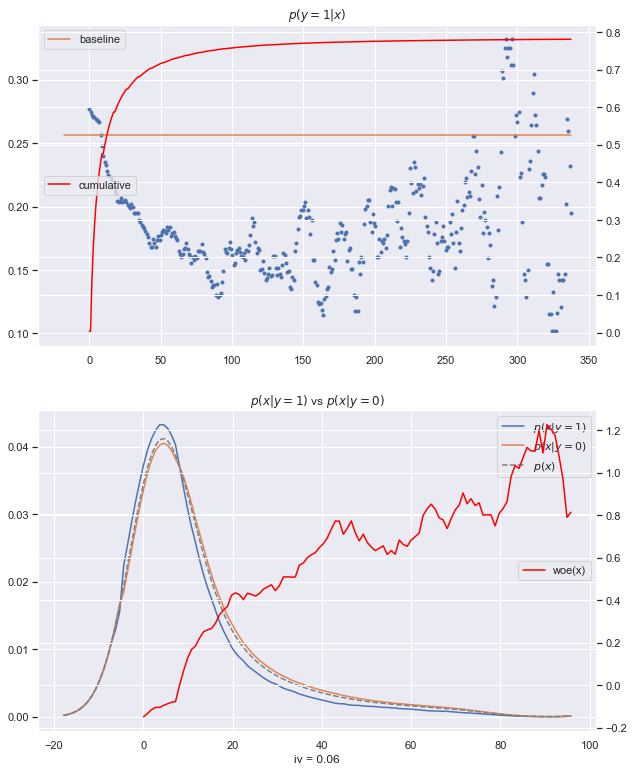

In [3]:
import check
from imp import reload
reload(check)
x,y= df['I3'].values,df['label'].values
n = y.shape[0]
#assert x.shape[0] = y.shape[0]
dist_y = pd.Series(y).value_counts()/n
f = check.feature_numeric(x)
f.fit(x,y)
f.summary()

In [16]:
x = df.loc[df['I3']<=60,'I3']

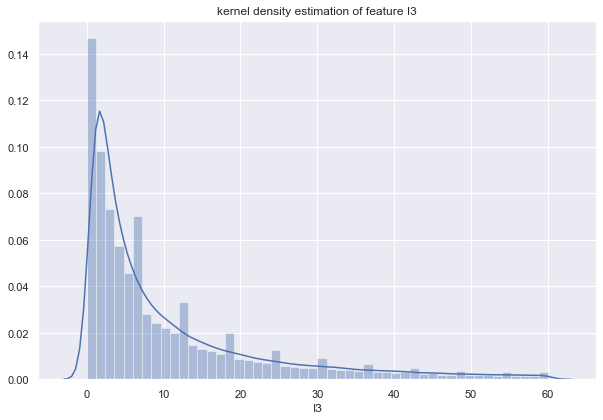

In [20]:
fig,ax = plt.subplots(figsize=[10,6.6])
sns.distplot(x,ax=ax)
ax.set_title('kernel density estimation of feature I3')
fig.savefig('kde1.png',dpi=200)


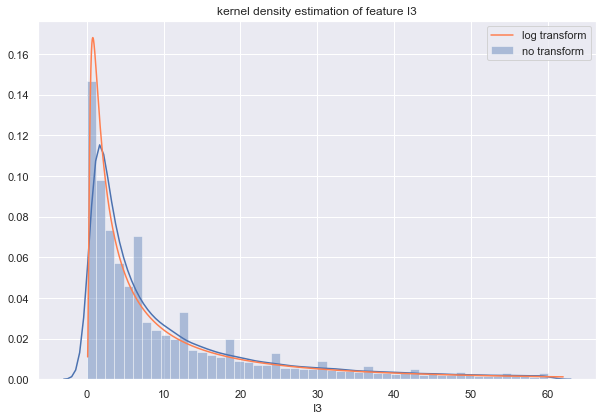

In [99]:
x = df.loc[df['I3']<=60,'I3']

fig,ax = plt.subplots(figsize=[10,6.6])
sns.distplot(x,ax=ax,label='no transform')

y = np.log2(x).astype(np.double)
dens = sm.nonparametric.KDEUnivariate(y)
dens.fit(bw=1.05)

support = dens.support
density = dens.density
support = 2**support
density = density/support/np.log(2)
ind = support<=62
ax.plot(support[ind],density[ind],color='coral',label='log transform');
ax.set_title('kernel density estimation of feature I3')
ax.legend()
fig.savefig('kde2.png',dpi=200)

In [ ]:
y = np.log(x)
fig,ax = plt.subplots(figsize=[10,6.6])
sns.distplot(x,ax=ax)
ax.set_title('kernel density estimation of feature I3')
fig.savefig('kde1.png',dpi=200)

3513

,name1,value1,name2,value2
0,n,100000,p(y=1),0.256430
1,missing,0.03513,p(y=0),0.743570
2,distinct_count,46455,iv,1.551041
3,distinct_count_normal,15,info_gain,1.115118
4,items_top3,"['d032c263', '02cf9876', 'aa8c1539']",info_gain_ratio,0.087416
5,entropy,12.7564,NaN,NaN


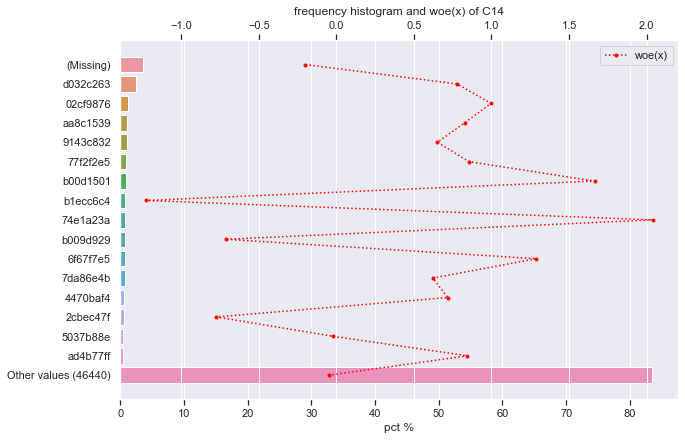

In [192]:
import check
from imp import reload
reload(check)

x,y= df['C3'],df['label']
display(np.sum(pd.Series(x).isnull()))
f1 = check.feature_categorical(name='C14')
f1.fit(x,y)
f1.summary()

$$
iv = \int [f(x|y=1) - f(x|y=0)] * \ln \frac{f(x|y=1)}{f(x|y=)}
$$

# 连续分布iv值计算方法



我们知道 

$$
\hat{f}_{h}(x) = \frac{1}{2h}\frac{\text{#}x_i\in [x-h,x+h]}{N}
$$

现在我们要计算 $\hat{f}_{h}(x|y=1)$  和 $\hat{f}_{h}(x|y=0)$, 令 

$$
\eta_x = \frac{\text{#}x_i\in [x-h,x+h]\cap (y=1)}{\text{#}x_i\in [x-h,x+h]}
$$

$$
\eta = p(y=1)
$$

可得

$$
\hat{f}_{h}(x|y=1) = \frac{1}{2h}\cdot\frac{\text{#}x_i\in [x-h,x+h]|_{y=1}}{N|_{y=1}} = \frac{\eta_x}{\eta} \cdot \hat{f}_{h}(x)
$$



$$
\eta = \frac{\text{#}x_i\in [x-h,x+h]|_{y=1}}{\text{#}x_i\in [x-h,x+h]}
$$